# R: Basic Instrumental Variables Calculation

In this example we show how to use the DoubleML functionality of Instrumental Variables (IVs) in the basic setting shown in the graph below, where:

- Z is the instrument
- C is a vector of unobserved confounders
- D is the decision or treatment variable
- Y is the outcome

So, we will first generate synthetic data using linear models compatible with the diagram, and then use the DoubleML package to estimate the causal effect from D to Y. 

We assume that you have basic knowledge of instrumental variables and linear regression.

In [ ]:
library(DoubleML)
library(mlr3learners)

set.seed(1234)
options(warn=-1)

## Instrumental Variables Directed Acyclic Graph (IV - DAG)

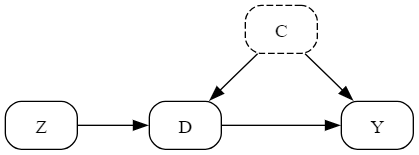

## Data Simulation

This code generates `n` samples in which there is a unique binary confounder. The treatment is also a binary variable, while the outcome is a continuous linear model. 

The quantity we want to recover using IVs is the `decision_impact`, which is the impact of the decision variable into the outcome. 

In [ ]:
n <- 10000
decision_effect <- -2
instrument_effect <- 0.7

confounder <- rbinom(n, 1, 0.3)
instrument <- rbinom(n, 1, 0.5)
decision <- as.numeric(runif(n) <= instrument_effect*instrument + 0.4*confounder)
outcome <- 30 + decision_effect*decision + 10 * confounder + rnorm(n, sd=2)
df <- data.frame(instrument, decision, outcome)

## Naive estimation

We can see that if we make a direct estimation of the impact of the `decision` into the `outcome`, though the difference of the averages of outcomes between the two decision groups, we obtain a biased estimate. 

In [ ]:
mean(df[df$decision==1, 'outcome']) - mean(df[df$decision==0, 'outcome'])

## Using DoubleML

DoubleML assumes that there is at least one observed confounder. For this reason, we create a fake variable that doesn't bring any kind of information to the model, called `obs_confounder`.

To use the DoubleML we need to specify the Machine Learning methods we want to use to estimate the different relationships between variables:

- `ml_g` models the functional relationship betwen the `outcome` and the pair `instrument` and observed confounders `obs_confounders`. In this case we choose a `LinearRegression` because the outcome is continuous. 
- `ml_m` models the functional relationship betwen the `obs_confounders` and the `instrument`. In this case we choose a `LogisticRegression` because the outcome is dichotomic.
- `ml_r` models the functional relationship betwen the `decision` and the pair `instrument` and observed confounders `obs_confounders`. In this case we choose a `LogisticRegression` because the outcome is dichotomic.


Notice that instead of using linear and logistic regression, we could use more flexible models capable of dealing with non-linearities such as random forests, boosting, ... 

In [ ]:
df['obs_confounders'] <- 1

obj_dml_data = DoubleMLData$new(
  df, y_col="outcome", d_col = "decision", 
  z_cols= "instrument", x_cols = "obs_confounders"
)

ml_g = lrn("regr.lm")
ml_m = lrn("classif.log_reg")
ml_r = ml_m$clone()

iv_2 = DoubleMLIIVM$new(obj_dml_data, ml_g, ml_m, ml_r)
result <- iv_2$fit()


In [ ]:
result

We can see that the causal effect is estimated without bias.

## References

Ruiz de Villa, A. Causal Inference for Data Science, Manning Publications, 2024.